# EuroSAT Dataset Applying Pre-trained CNN GoogleNet

In [16]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [17]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [18]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [19]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: HerbaceousVegetation --> count: 3000
class: AnnualCrop --> count: 3000
class: Forest --> count: 3000
class: SeaLake --> count: 3000
class: Residential --> count: 3000
class: PermanentCrop --> count: 2500
class: Industrial --> count: 2500
class: River --> count: 2500
class: Highway --> count: 2500
class: Pasture --> count: 2000


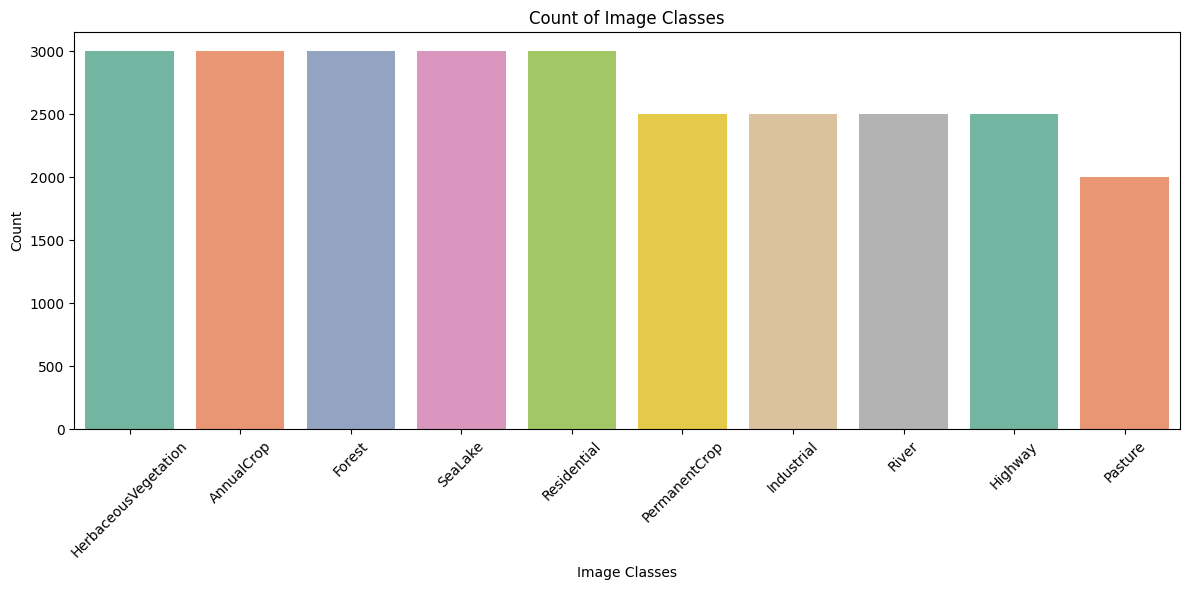

In [20]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

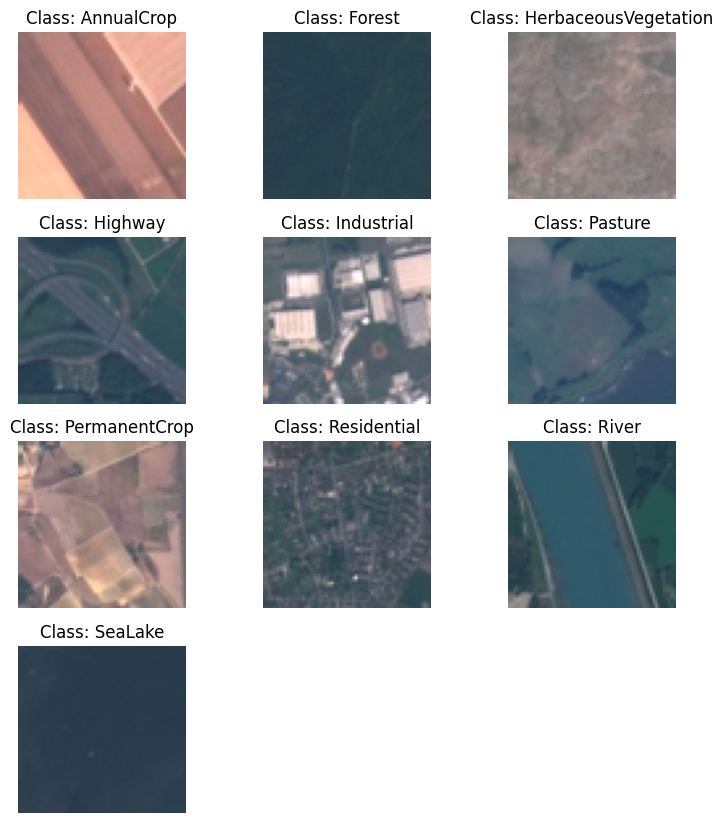

In [21]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [22]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [23]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [24]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

Lable mapping

In [25]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [27]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [28]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [29]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = {class_name: i for i, class_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



In [30]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])
    
    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Neural Network (GoogleNet)

In [31]:
total_class = 10
learning_rate = 0.0001

model = models.googlenet(pretrained=False, aux_logits=True)

model.fc = nn.Linear(model.fc.in_features, total_class)

if model.aux1:
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, total_class)

if model.aux2:
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, total_class)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

### Training

In [33]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=150, early_stop_patience=150, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs, aux1, aux2 = model(inputs) if model.aux_logits else (model(inputs), None, None)

            loss_main = criterion(outputs, labels)
            loss_aux1 = criterion(aux1, labels) if aux1 is not None else 0
            loss_aux2 = criterion(aux2, labels) if aux2 is not None else 0

            # Total loss: main + 0.3 * each aux
            loss = loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.78, loss=1.05] 

Training Loss: 1.053 Acc: 0.780


Validation Loss: 5.566 Acc: 0.147
✅ Best model saved at epoch 1 with validation accuracy: 0.147


Epoch 2/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.831, loss=0.805]

Training Loss: 0.805 Acc: 0.831


Validation Loss: 3.380 Acc: 0.210
✅ Best model saved at epoch 2 with validation accuracy: 0.210


Epoch 3/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.867, loss=0.644]

Training Loss: 0.644 Acc: 0.867


Validation Loss: 3.292 Acc: 0.255
✅ Best model saved at epoch 3 with validation accuracy: 0.255


Epoch 4/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.889, loss=0.537]

Training Loss: 0.537 Acc: 0.889


Validation Loss: 4.083 Acc: 0.230


Epoch 5/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.896, loss=0.489]

Training Loss: 0.489 Acc: 0.896


Validation Loss: 3.009 Acc: 0.240


Epoch 6/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.913, loss=0.404]

Training Loss: 0.404 Acc: 0.913


Validation Loss: 2.946 Acc: 0.286
✅ Best model saved at epoch 6 with validation accuracy: 0.286


Epoch 7/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.917, loss=0.401]

Training Loss: 0.401 Acc: 0.917


Validation Loss: 4.551 Acc: 0.271


Epoch 8/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.922, loss=0.359]

Training Loss: 0.359 Acc: 0.922


Validation Loss: 3.982 Acc: 0.251


Epoch 9/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.932, loss=0.324]

Training Loss: 0.324 Acc: 0.932


Validation Loss: 3.255 Acc: 0.304
✅ Best model saved at epoch 9 with validation accuracy: 0.304


Epoch 10/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.931, loss=0.331]

Training Loss: 0.331 Acc: 0.931


Validation Loss: 3.971 Acc: 0.289


Epoch 11/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.937, loss=0.299]

Training Loss: 0.299 Acc: 0.937


Validation Loss: 4.960 Acc: 0.184


Epoch 12/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.937, loss=0.296]

Training Loss: 0.296 Acc: 0.937


Validation Loss: 4.570 Acc: 0.256


Epoch 13/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.942, loss=0.274]

Training Loss: 0.274 Acc: 0.942


Validation Loss: 3.455 Acc: 0.284


Epoch 14/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.939, loss=0.28] 

Training Loss: 0.280 Acc: 0.939


Validation Loss: 5.056 Acc: 0.225


Epoch 15/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.946, loss=0.252]

Training Loss: 0.252 Acc: 0.946


Validation Loss: 4.367 Acc: 0.234


Epoch 16/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.948, loss=0.241]

Training Loss: 0.241 Acc: 0.948


Validation Loss: 4.146 Acc: 0.252


Epoch 17/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.947, loss=0.245]

Training Loss: 0.245 Acc: 0.947


Validation Loss: 4.694 Acc: 0.312
✅ Best model saved at epoch 17 with validation accuracy: 0.312


Epoch 18/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.955, loss=0.213]

Training Loss: 0.213 Acc: 0.955


Validation Loss: 4.138 Acc: 0.278


Epoch 19/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.953, loss=0.22] 

Training Loss: 0.220 Acc: 0.953


Validation Loss: 5.263 Acc: 0.243


Epoch 20/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.954, loss=0.21] 

Training Loss: 0.210 Acc: 0.954


Validation Loss: 3.696 Acc: 0.284


Epoch 21/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.957, loss=0.206]

Training Loss: 0.206 Acc: 0.957


Validation Loss: 3.973 Acc: 0.274


Epoch 22/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.957, loss=0.196]

Training Loss: 0.196 Acc: 0.957


Validation Loss: 6.770 Acc: 0.170


Epoch 23/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.957, loss=0.2]  

Training Loss: 0.200 Acc: 0.957


Validation Loss: 5.084 Acc: 0.238


Epoch 24/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.959, loss=0.189]

Training Loss: 0.189 Acc: 0.959


Validation Loss: 5.739 Acc: 0.225


Epoch 25/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.96, loss=0.186] 

Training Loss: 0.186 Acc: 0.960


Validation Loss: 4.905 Acc: 0.177


Epoch 26/150: 100%|██████████| 296/296 [00:52<00:00,  5.58it/s, acc=0.956, loss=0.199]

Training Loss: 0.199 Acc: 0.956


Validation Loss: 4.702 Acc: 0.240


Epoch 27/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.965, loss=0.16] 

Training Loss: 0.160 Acc: 0.965


Validation Loss: 5.404 Acc: 0.251


Epoch 28/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.965, loss=0.164]

Training Loss: 0.164 Acc: 0.965


Validation Loss: 4.786 Acc: 0.235


Epoch 29/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.965, loss=0.16] 

Training Loss: 0.160 Acc: 0.965


Validation Loss: 5.611 Acc: 0.273


Epoch 30/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.968, loss=0.155]

Training Loss: 0.155 Acc: 0.968


Validation Loss: 6.429 Acc: 0.208


Epoch 31/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.966, loss=0.158]

Training Loss: 0.158 Acc: 0.966


Validation Loss: 4.839 Acc: 0.254


Epoch 32/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.967, loss=0.154]

Training Loss: 0.154 Acc: 0.967


Validation Loss: 5.281 Acc: 0.198


Epoch 33/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.968, loss=0.149]

Training Loss: 0.149 Acc: 0.968


Validation Loss: 4.155 Acc: 0.362
✅ Best model saved at epoch 33 with validation accuracy: 0.362


Epoch 34/150: 100%|██████████| 296/296 [00:53<00:00,  5.56it/s, acc=0.969, loss=0.142]

Training Loss: 0.142 Acc: 0.969


Validation Loss: 5.099 Acc: 0.290


Epoch 35/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.972, loss=0.129]

Training Loss: 0.129 Acc: 0.972


Validation Loss: 5.075 Acc: 0.259


Epoch 36/150: 100%|██████████| 296/296 [00:53<00:00,  5.57it/s, acc=0.973, loss=0.129]

Training Loss: 0.129 Acc: 0.973


Validation Loss: 8.095 Acc: 0.296


Epoch 37/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.971, loss=0.138]

Training Loss: 0.138 Acc: 0.971


Validation Loss: 7.984 Acc: 0.238


Epoch 38/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.974, loss=0.127]

Training Loss: 0.127 Acc: 0.974


Validation Loss: 5.437 Acc: 0.282


Epoch 39/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.972, loss=0.128]

Training Loss: 0.128 Acc: 0.972


Validation Loss: 5.263 Acc: 0.278


Epoch 40/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.973, loss=0.125]

Training Loss: 0.125 Acc: 0.973


Validation Loss: 8.331 Acc: 0.205


Epoch 41/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.972, loss=0.127]

Training Loss: 0.127 Acc: 0.972


Validation Loss: 8.185 Acc: 0.213


Epoch 42/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.977, loss=0.111] 

Training Loss: 0.111 Acc: 0.977


Validation Loss: 8.364 Acc: 0.195


Epoch 43/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.972, loss=0.127]

Training Loss: 0.127 Acc: 0.972


Validation Loss: 7.067 Acc: 0.264


Epoch 44/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.975, loss=0.116]

Training Loss: 0.116 Acc: 0.975


Validation Loss: 7.175 Acc: 0.220


Epoch 45/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.978, loss=0.105] 

Training Loss: 0.105 Acc: 0.978


Validation Loss: 8.344 Acc: 0.267


Epoch 46/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.975, loss=0.12] 

Training Loss: 0.120 Acc: 0.975


Validation Loss: 9.200 Acc: 0.185


Epoch 47/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.978, loss=0.106]

Training Loss: 0.106 Acc: 0.978


Validation Loss: 7.917 Acc: 0.175


Epoch 48/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.977, loss=0.112]

Training Loss: 0.112 Acc: 0.977


Validation Loss: 6.901 Acc: 0.250


Epoch 49/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.977, loss=0.103] 

Training Loss: 0.103 Acc: 0.977


Validation Loss: 6.742 Acc: 0.240


Epoch 50/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.978, loss=0.103] 

Training Loss: 0.103 Acc: 0.978


Validation Loss: 5.306 Acc: 0.247


Epoch 51/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.981, loss=0.0881]

Training Loss: 0.088 Acc: 0.981


Validation Loss: 7.551 Acc: 0.210


Epoch 52/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.979, loss=0.103] 

Training Loss: 0.103 Acc: 0.979


Validation Loss: 6.999 Acc: 0.239


Epoch 53/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.981, loss=0.0956]

Training Loss: 0.096 Acc: 0.981


Validation Loss: 8.459 Acc: 0.206


Epoch 54/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.981, loss=0.0883]

Training Loss: 0.088 Acc: 0.981


Validation Loss: 6.403 Acc: 0.210


Epoch 55/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.982, loss=0.086] 

Training Loss: 0.086 Acc: 0.982


Validation Loss: 8.172 Acc: 0.234


Epoch 56/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.98, loss=0.0925] 

Training Loss: 0.092 Acc: 0.980


Validation Loss: 8.068 Acc: 0.221


Epoch 57/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.982, loss=0.0881]

Training Loss: 0.088 Acc: 0.982


Validation Loss: 5.946 Acc: 0.308


Epoch 58/150: 100%|██████████| 296/296 [00:52<00:00,  5.63it/s, acc=0.982, loss=0.087] 

Training Loss: 0.087 Acc: 0.982


Validation Loss: 7.008 Acc: 0.286


Epoch 59/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.983, loss=0.0849]

Training Loss: 0.085 Acc: 0.983


Validation Loss: 9.458 Acc: 0.199


Epoch 60/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.984, loss=0.0758]

Training Loss: 0.076 Acc: 0.984


Validation Loss: 12.535 Acc: 0.167


Epoch 61/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.983, loss=0.0847]

Training Loss: 0.085 Acc: 0.983


Validation Loss: 8.169 Acc: 0.217


Epoch 62/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.984, loss=0.077] 

Training Loss: 0.077 Acc: 0.984


Validation Loss: 9.117 Acc: 0.209


Epoch 63/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.985, loss=0.0739]

Training Loss: 0.074 Acc: 0.985


Validation Loss: 10.282 Acc: 0.232


Epoch 64/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.986, loss=0.0734]

Training Loss: 0.073 Acc: 0.986


Validation Loss: 10.556 Acc: 0.182


Epoch 65/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.985, loss=0.0728]

Training Loss: 0.073 Acc: 0.985


Validation Loss: 7.840 Acc: 0.265


Epoch 66/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.983, loss=0.0814]

Training Loss: 0.081 Acc: 0.983


Validation Loss: 7.769 Acc: 0.268


Epoch 67/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.983, loss=0.0815]

Training Loss: 0.081 Acc: 0.983


Validation Loss: 12.396 Acc: 0.184


Epoch 68/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.987, loss=0.0632]

Training Loss: 0.063 Acc: 0.987


Validation Loss: 9.754 Acc: 0.264


Epoch 69/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.987, loss=0.0654]

Training Loss: 0.065 Acc: 0.987


Validation Loss: 11.867 Acc: 0.159


Epoch 70/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.987, loss=0.0687]

Training Loss: 0.069 Acc: 0.987


Validation Loss: 10.695 Acc: 0.176


Epoch 71/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.987, loss=0.0615]

Training Loss: 0.061 Acc: 0.987


Validation Loss: 7.602 Acc: 0.273


Epoch 72/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.988, loss=0.0605]

Training Loss: 0.061 Acc: 0.988


Validation Loss: 8.835 Acc: 0.246


Epoch 73/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.987, loss=0.0648]

Training Loss: 0.065 Acc: 0.987


Validation Loss: 8.695 Acc: 0.310


Epoch 74/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.985, loss=0.0721]

Training Loss: 0.072 Acc: 0.985


Validation Loss: 8.395 Acc: 0.218


Epoch 75/150:  67%|██████▋   | 198/296 [00:35<00:17,  5.75it/s, acc=0.988, loss=0.0624]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Epoch 75/150:  67%|██████▋   | 199/296 [00:35<00:17,  5.40it/s, acc=0.988, loss=0.0622]can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/da

Training Loss: 0.062 Acc: 0.988


Validation Loss: 8.131 Acc: 0.287


Epoch 76/150:  18%|█▊        | 53/296 [00:09<00:43,  5.59it/s, acc=0.986, loss=0.0659]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Epoch 76/150:  18%|█▊        | 54/296 [00:10<00:42,  5.72it/s, acc=0.987, loss=0.0661]          ^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __d

Training Loss: 0.055 Acc: 0.990


Validation Loss: 8.844 Acc: 0.258


Epoch 77/150:  12%|█▎        | 37/296 [00:07<00:46,  5.57it/s, acc=0.991, loss=0.0487]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
Epoch 77/150:  13%|█▎        | 38/296 [00:07<00:45,  5.69it/s, acc=0.99, loss=0.0498]     assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/

Training Loss: 0.055 Acc: 0.989


Validation Loss: 11.350 Acc: 0.191


Epoch 78/150:   7%|▋         | 21/296 [00:04<00:49,  5.61it/s, acc=0.985, loss=0.0865]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
Epoch 78/150:   7%|▋         | 22/296 [00:04<00:47,  5.76it/s, acc=0.985, loss=0.0863]    ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>

AssertionErrorTraceback (most recent call last):
: can only test a child process  File "/usr/local/lib/python3.11/dist-packages/torc

Training Loss: 0.075 Acc: 0.985



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():
    Exception ignored in:  self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0> 
 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      

Validation Loss: 9.603 Acc: 0.232


Epoch 79/150:   4%|▎         | 11/296 [00:02<00:53,  5.31it/s, acc=0.987, loss=0.0765]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Epoch 79/150:   4%|▍         | 12/296 [00:02<00:51,  5.52it/s, acc=0.988, loss=0.0736]    if w.is_alive():
       ^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^^    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/lib/python3.11/multiprocessing/pro

Training Loss: 0.059 Acc: 0.987



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
Traceback (most recent call last):
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
    
Traceback (most recent call last):
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
            if w.is_alive():self._shutdown_workers()self._shutdown_workers()


   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, i

Validation Loss: 8.152 Acc: 0.321


Epoch 80/150:   1%|          | 2/296 [00:00<02:02,  2.41it/s, acc=0.984, loss=0.0764]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():^

   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == 

Training Loss: 0.056 Acc: 0.989



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7c707741f9c0> 
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^  ^  ^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^  ^^ ^ ^ ^ ^ 
  File "/usr/l

Validation Loss: 9.259 Acc: 0.217


Epoch 81/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.988, loss=0.0596]

Training Loss: 0.060 Acc: 0.988


Validation Loss: 8.244 Acc: 0.278


Epoch 82/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.99, loss=0.053]  

Training Loss: 0.053 Acc: 0.990


Validation Loss: 8.552 Acc: 0.234


Epoch 83/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.99, loss=0.054]  

Training Loss: 0.054 Acc: 0.990


Validation Loss: 8.709 Acc: 0.211


Epoch 84/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.989, loss=0.0546]

Training Loss: 0.055 Acc: 0.989


Validation Loss: 9.993 Acc: 0.198


Epoch 85/150: 100%|██████████| 296/296 [00:53<00:00,  5.57it/s, acc=0.99, loss=0.0554] 

Training Loss: 0.055 Acc: 0.990


Validation Loss: 8.772 Acc: 0.210


Epoch 86/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.99, loss=0.05]   

Training Loss: 0.050 Acc: 0.990


Validation Loss: 11.030 Acc: 0.193


Epoch 87/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.99, loss=0.0523] 

Training Loss: 0.052 Acc: 0.990


Validation Loss: 9.441 Acc: 0.225


Epoch 88/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.989, loss=0.0543]

Training Loss: 0.054 Acc: 0.989


Validation Loss: 10.415 Acc: 0.229


Epoch 89/150: 100%|██████████| 296/296 [00:53<00:00,  5.57it/s, acc=0.991, loss=0.046] 

Training Loss: 0.046 Acc: 0.991


Validation Loss: 10.065 Acc: 0.206


Epoch 90/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.989, loss=0.0577]

Training Loss: 0.058 Acc: 0.989


Validation Loss: 10.328 Acc: 0.265


Epoch 91/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.99, loss=0.0544] 

Training Loss: 0.054 Acc: 0.990


Validation Loss: 7.436 Acc: 0.263


Epoch 92/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.992, loss=0.0397]

Training Loss: 0.040 Acc: 0.992


Validation Loss: 8.749 Acc: 0.268


Epoch 93/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.99, loss=0.05]   

Training Loss: 0.050 Acc: 0.990


Validation Loss: 8.340 Acc: 0.279


Epoch 94/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.991, loss=0.0442]

Training Loss: 0.044 Acc: 0.991


Validation Loss: 8.345 Acc: 0.246


Epoch 95/150: 100%|██████████| 296/296 [00:53<00:00,  5.57it/s, acc=0.99, loss=0.0501] 

Training Loss: 0.050 Acc: 0.990


Validation Loss: 7.811 Acc: 0.270


Epoch 96/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.989, loss=0.0482]

Training Loss: 0.048 Acc: 0.989


Validation Loss: 8.234 Acc: 0.337


Epoch 97/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.99, loss=0.0484] 

Training Loss: 0.048 Acc: 0.990


Validation Loss: 9.773 Acc: 0.214


Epoch 98/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.991, loss=0.0455]

Training Loss: 0.045 Acc: 0.991


Validation Loss: 9.683 Acc: 0.170


Epoch 99/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.99, loss=0.0521] 

Training Loss: 0.052 Acc: 0.990


Validation Loss: 10.663 Acc: 0.208


Epoch 100/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.993, loss=0.0369]

Training Loss: 0.037 Acc: 0.993


Validation Loss: 8.572 Acc: 0.228


Epoch 101/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.993, loss=0.0386]

Training Loss: 0.039 Acc: 0.993


Validation Loss: 8.818 Acc: 0.221


Epoch 102/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.989, loss=0.053] 

Training Loss: 0.053 Acc: 0.989


Validation Loss: 7.769 Acc: 0.252


Epoch 103/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.993, loss=0.0406]

Training Loss: 0.041 Acc: 0.993


Validation Loss: 7.155 Acc: 0.199


Epoch 104/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.99, loss=0.0522] 

Training Loss: 0.052 Acc: 0.990


Validation Loss: 7.844 Acc: 0.217


Epoch 105/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.992, loss=0.0409]

Training Loss: 0.041 Acc: 0.992


Validation Loss: 10.065 Acc: 0.178


Epoch 106/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.992, loss=0.0428]

Training Loss: 0.043 Acc: 0.992


Validation Loss: 8.812 Acc: 0.253


Epoch 107/150: 100%|██████████| 296/296 [00:53<00:00,  5.57it/s, acc=0.993, loss=0.0376]

Training Loss: 0.038 Acc: 0.993


Validation Loss: 9.278 Acc: 0.237


Epoch 108/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.993, loss=0.0362]

Training Loss: 0.036 Acc: 0.993


Validation Loss: 9.503 Acc: 0.222


Epoch 109/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.99, loss=0.051]  

Training Loss: 0.051 Acc: 0.990


Validation Loss: 8.651 Acc: 0.223


Epoch 110/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.993, loss=0.0353]

Training Loss: 0.035 Acc: 0.993


Validation Loss: 9.921 Acc: 0.199


Epoch 111/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.991, loss=0.044] 

Training Loss: 0.044 Acc: 0.991


Validation Loss: 8.814 Acc: 0.183


Epoch 112/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.994, loss=0.0362]

Training Loss: 0.036 Acc: 0.994


Validation Loss: 8.724 Acc: 0.192


Epoch 113/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.992, loss=0.0395]

Training Loss: 0.039 Acc: 0.992


Validation Loss: 10.141 Acc: 0.213


Epoch 114/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.992, loss=0.0438]

Training Loss: 0.044 Acc: 0.992


Validation Loss: 10.462 Acc: 0.197


Epoch 115/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.992, loss=0.0411]

Training Loss: 0.041 Acc: 0.992


Validation Loss: 10.136 Acc: 0.190


Epoch 116/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.994, loss=0.0314]

Training Loss: 0.031 Acc: 0.994


Validation Loss: 10.327 Acc: 0.207


Epoch 117/150: 100%|██████████| 296/296 [00:53<00:00,  5.57it/s, acc=0.994, loss=0.0322]

Training Loss: 0.032 Acc: 0.994


Validation Loss: 10.757 Acc: 0.177


Epoch 118/150: 100%|██████████| 296/296 [00:53<00:00,  5.57it/s, acc=0.994, loss=0.0349]

Training Loss: 0.035 Acc: 0.994


Validation Loss: 9.802 Acc: 0.248


Epoch 119/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.994, loss=0.0349]

Training Loss: 0.035 Acc: 0.994


Validation Loss: 9.562 Acc: 0.196


Epoch 120/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.992, loss=0.0371]

Training Loss: 0.037 Acc: 0.992


Validation Loss: 10.003 Acc: 0.181


Epoch 121/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.992, loss=0.0391]

Training Loss: 0.039 Acc: 0.992


Validation Loss: 11.838 Acc: 0.191


Epoch 122/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.994, loss=0.0362]

Training Loss: 0.036 Acc: 0.994


Validation Loss: 9.273 Acc: 0.213


Epoch 123/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.993, loss=0.0358]

Training Loss: 0.036 Acc: 0.993


Validation Loss: 12.845 Acc: 0.186


Epoch 124/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.995, loss=0.0315]

Training Loss: 0.032 Acc: 0.995


Validation Loss: 13.414 Acc: 0.180


Epoch 125/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.995, loss=0.0291]

Training Loss: 0.029 Acc: 0.995


Validation Loss: 11.943 Acc: 0.195


Epoch 126/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.993, loss=0.0348]

Training Loss: 0.035 Acc: 0.993


Validation Loss: 10.985 Acc: 0.204


Epoch 127/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.993, loss=0.0367]

Training Loss: 0.037 Acc: 0.993


Validation Loss: 11.793 Acc: 0.212


Epoch 128/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.993, loss=0.0365]

Training Loss: 0.036 Acc: 0.993


Validation Loss: 11.886 Acc: 0.210


Epoch 129/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.993, loss=0.0336]

Training Loss: 0.034 Acc: 0.993


Validation Loss: 10.011 Acc: 0.287


Epoch 130/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.994, loss=0.0325]

Training Loss: 0.032 Acc: 0.994


Validation Loss: 9.450 Acc: 0.217


Epoch 131/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.992, loss=0.0428]

Training Loss: 0.043 Acc: 0.992


Validation Loss: 10.627 Acc: 0.232


Epoch 132/150: 100%|██████████| 296/296 [00:52<00:00,  5.63it/s, acc=0.995, loss=0.03]  

Training Loss: 0.030 Acc: 0.995


Validation Loss: 11.185 Acc: 0.201


Epoch 133/150: 100%|██████████| 296/296 [00:52<00:00,  5.63it/s, acc=0.996, loss=0.0221]

Training Loss: 0.022 Acc: 0.996


Validation Loss: 12.226 Acc: 0.173


Epoch 134/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.993, loss=0.0358]

Training Loss: 0.036 Acc: 0.993


Validation Loss: 9.414 Acc: 0.206


Epoch 135/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.994, loss=0.0316]

Training Loss: 0.032 Acc: 0.994


Validation Loss: 10.393 Acc: 0.200


Epoch 136/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.997, loss=0.0194]

Training Loss: 0.019 Acc: 0.997


Validation Loss: 10.535 Acc: 0.176


Epoch 137/150: 100%|██████████| 296/296 [00:52<00:00,  5.63it/s, acc=0.994, loss=0.0342]

Training Loss: 0.034 Acc: 0.994


Validation Loss: 10.305 Acc: 0.182


Epoch 138/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.995, loss=0.0301]

Training Loss: 0.030 Acc: 0.995


Validation Loss: 11.834 Acc: 0.189


Epoch 139/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.995, loss=0.0285]

Training Loss: 0.028 Acc: 0.995


Validation Loss: 10.007 Acc: 0.223


Epoch 140/150: 100%|██████████| 296/296 [00:52<00:00,  5.63it/s, acc=0.995, loss=0.0279]

Training Loss: 0.028 Acc: 0.995


Validation Loss: 10.545 Acc: 0.201


Epoch 141/150: 100%|██████████| 296/296 [00:52<00:00,  5.64it/s, acc=0.995, loss=0.0325]

Training Loss: 0.032 Acc: 0.995


Validation Loss: 10.438 Acc: 0.232


Epoch 142/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.995, loss=0.0309]

Training Loss: 0.031 Acc: 0.995


Validation Loss: 10.261 Acc: 0.198


Epoch 143/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.994, loss=0.0347]

Training Loss: 0.035 Acc: 0.994


Validation Loss: 10.590 Acc: 0.259


Epoch 144/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.996, loss=0.0236]

Training Loss: 0.024 Acc: 0.996


Validation Loss: 10.236 Acc: 0.235


Epoch 145/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.996, loss=0.0254]

Training Loss: 0.025 Acc: 0.996


Validation Loss: 11.881 Acc: 0.177


Epoch 146/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.995, loss=0.03]  

Training Loss: 0.030 Acc: 0.995


Validation Loss: 9.136 Acc: 0.248


Epoch 147/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.996, loss=0.0226]

Training Loss: 0.023 Acc: 0.996


Validation Loss: 10.255 Acc: 0.235


Epoch 148/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.995, loss=0.0289]

Training Loss: 0.029 Acc: 0.995


Validation Loss: 9.912 Acc: 0.194


Epoch 149/150: 100%|██████████| 296/296 [00:52<00:00,  5.61it/s, acc=0.995, loss=0.0268]

Training Loss: 0.027 Acc: 0.995


Validation Loss: 8.926 Acc: 0.172


Epoch 150/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.995, loss=0.0279]

Training Loss: 0.028 Acc: 0.995


Validation Loss: 9.820 Acc: 0.167
⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for 150 consecutive epochs. Training stopped.
Training Time: 9275.37 seconds ---> 154.59 minutes


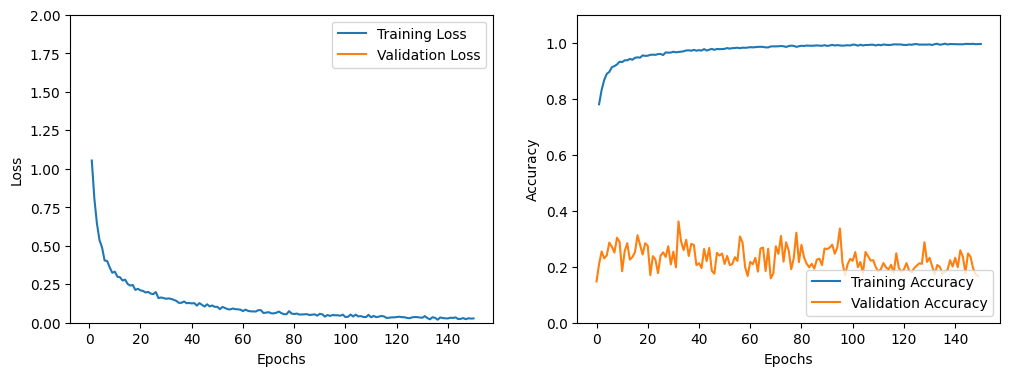

In [34]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [35]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 33) - Validation Loss: 4.168, Validation Accuracy: 0.362


In [36]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.368
Test Time: 10.16 seconds ---> 0.17 minutes


In [37]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
           
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.49      0.51       450
           1       0.00      0.00      0.00       450
           2       0.15      0.04      0.07       450
           3       0.00      0.00      0.00       375
           4       0.70      0.97      0.82       375
           5       0.00      0.00      0.00       300
           6       0.67      0.26      0.37       375
           7       0.56      0.77      0.65       450
           8       0.00      0.00      0.00       375
           9       0.20      0.99      0.34       450

    accuracy                           0.37      4050
   macro avg       0.28      0.35      0.27      4050
weighted avg       0.29      0.37      0.28      4050



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 Accuracy: 0.480
Class 1 Accuracy: 0.000
Class 2 Accuracy: 0.040
Class 3 Accuracy: 0.000
Class 4 Accuracy: 0.968
Class 5 Accuracy: 0.000
Class 6 Accuracy: 0.264
Class 7 Accuracy: 0.773
Class 8 Accuracy: 0.000
Class 9 Accuracy: 0.991


### Confusion Matrix

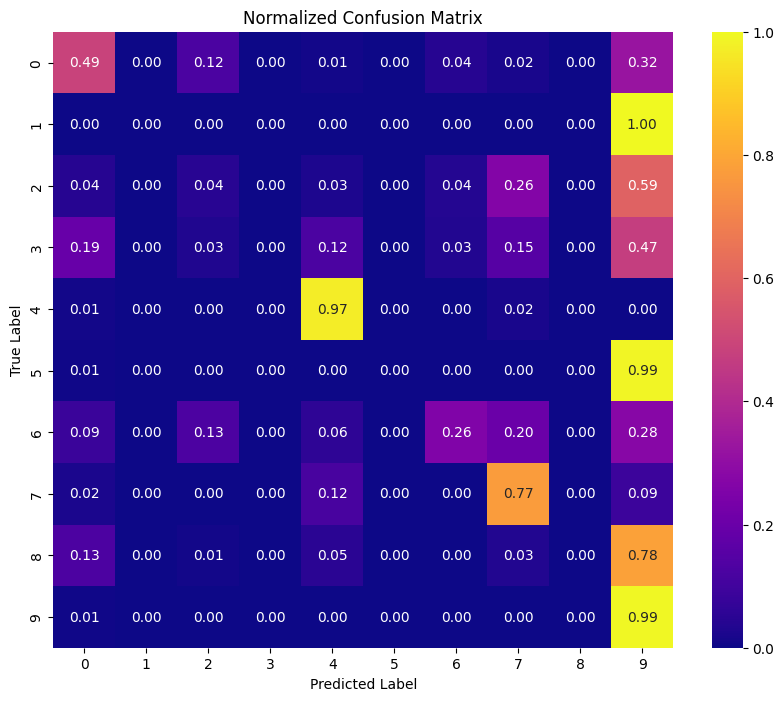

In [38]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC ROC Curve

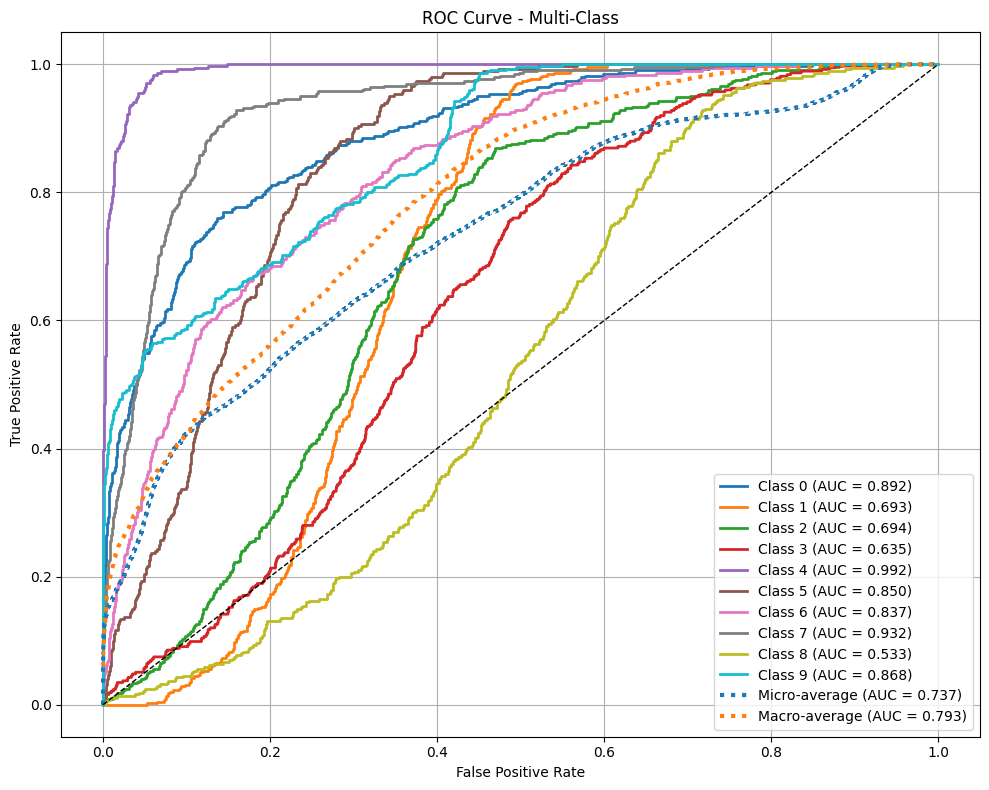

In [39]:
# Binarize the true labels
classes_list = sorted(list(set(y_true)))
y_true_bin = label_binarize(y_true, classes=classes_list)

fpr, tpr, roc_auc = {}, {}, {}

# Per-class ROC & AUC
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(total_class)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(total_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= total_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ----- Plot ROC curves -----
plt.figure(figsize=(10, 8))

# Per-class curves
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {classes_list[i]} (AUC = {roc_auc[i]:.3f})")

# Micro and Macro curves
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()